In [29]:
!pip install pandas xgboost numpy scikit-learn duckdb

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb

# Cargar los datos desde DuckDB
conn = duckdb.connect('devlake_data.duckdb')
data = conn.execute("SELECT * FROM ds_pr_time_summary_monthly").df()

In [42]:
# Consulta para agrupar equipos por producto
query_equipos_por_producto = """
SELECT 
    producto,
    equipo,
    COUNT(*) as total_registros,
    SUM(total_cycle_time) as cycle_time_total,
    SUM(total_coding_time) as coding_time_total,
    SUM(total_review_time) as review_time_total,
    SUM(total_deploy_time) as deploy_time_total,
    SUM(total_prs) as prs_total
FROM ds_pr_time_summary_monthly 
GROUP BY producto, equipo
ORDER BY producto, cycle_time_total DESC
"""

# Ejecutar la consulta
equipos_por_producto = conn.execute(query_equipos_por_producto).df()

# Mostrar los resultados
print("Equipos agrupados por producto:")
print(equipos_por_producto.head(20))

# Ver resumen por producto
resumen_productos = equipos_por_producto.groupby('producto').agg({
    'cycle_time_total': 'sum',
    'coding_time_total': 'sum', 
    'review_time_total': 'sum',
    'deploy_time_total': 'sum',
    'prs_total': 'sum',
    'equipo': 'count'
}).rename(columns={'equipo': 'cantidad_equipos'})

print("\nResumen por producto:")
print(resumen_productos)


Equipos agrupados por producto:
                    producto         equipo  total_registros  \
0                        App  Storefront SM               10   
1           Backoffice SM CL     Picking SM               10   
2                     Config            PIM               10   
3  Connectors & Integrations            PIM               10   
4                Picking HUB     Picking SM                9   

   cycle_time_total  coding_time_total  review_time_total  deploy_time_total  \
0      7.199341e+07       7.624174e+07          4632179.0       6.592980e+07   
1      2.622299e+08       6.171274e+08          9711184.0       2.221655e+07   
2      1.341345e+10       7.365315e+09        284039781.0       1.174725e+10   
3      8.477861e+09       6.752664e+09        216984339.0       6.611797e+09   
4      1.865018e+09       1.520930e+09        304411107.0       1.593614e+09   

   prs_total  
0     5766.0  
1    14415.0  
2   354744.0  
3   156152.0  
4    75712.0  

Resumen por

In [32]:
data.describe()

,total_cycle_time,total_coding_time,total_review_time,total_deploy_time,total_prs
count,3.400000e+01,4.900000e+01,4.900000e+01,3.400000e+01,49.000000
mean,7.085456e+08,3.333118e+08,1.673018e+07,5.894356e+08,12383.448980
std,1.932984e+09,8.814755e+08,4.522802e+07,1.739593e+09,32729.286102
min,1.920100e+04,1.501500e+04,7.130000e+02,1.333000e+03,182.000000
25%,3.908944e+07,3.968653e+06,2.938800e+05,6.932018e+06,459.000000
50%,1.962004e+08,5.459916e+07,2.183699e+06,5.740211e+07,2730.000000
75%,4.482259e+08,2.766468e+08,1.252530e+07,3.768272e+08,11266.000000
max,1.041173e+10,5.056234e+09,2.868213e+08,9.302956e+09,216747.000000


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   producto           49 non-null     object 
 1   equipo             49 non-null     object 
 2   anio_mes           49 non-null     object 
 3   total_cycle_time   34 non-null     float64
 4   total_coding_time  49 non-null     float64
 5   total_review_time  49 non-null     float64
 6   total_deploy_time  34 non-null     float64
 7   total_prs          49 non-null     int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 3.2+ KB


In [34]:
# Convertir la columna anio_mes a datetime
data['anio_mes'] = pd.to_datetime(data['anio_mes'])


In [48]:
# Reemplazar valores nulos/NaN en las columnas especificadas
data_without_nulls = data.copy()

# Reemplazar NaN con 0 en las columnas especificadas
columns_to_fill = ['total_cycle_time', 'total_deploy_time']
data_without_nulls[columns_to_fill] = data_without_nulls[columns_to_fill].fillna(0)

print("Valores nulos antes del reemplazo:")
print(data[columns_to_fill].isnull().sum())

print("\nValores nulos después del reemplazo:")
print(data_without_nulls[columns_to_fill].isnull().sum())

print(f"\nDataFrame original: {data.shape}")
print(f"DataFrame sin nulos: {data_without_nulls.shape}")


Valores nulos antes del reemplazo:
total_cycle_time     15
total_deploy_time    15
dtype: int64

Valores nulos después del reemplazo:
total_cycle_time     0
total_deploy_time    0
dtype: int64

DataFrame original: (49, 8)
DataFrame sin nulos: (49, 8)


In [49]:
data_without_nulls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   producto           49 non-null     object        
 1   equipo             49 non-null     object        
 2   anio_mes           49 non-null     datetime64[ns]
 3   total_cycle_time   49 non-null     float64       
 4   total_coding_time  49 non-null     float64       
 5   total_review_time  49 non-null     float64       
 6   total_deploy_time  49 non-null     float64       
 7   total_prs          49 non-null     int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 3.2+ KB


In [50]:
data_without_nulls

,producto,equipo,anio_mes,total_cycle_time,total_coding_time,total_review_time,total_deploy_time,total_prs
0,Config,PIM,2024-10-01,1.041173e+10,5.056234e+09,101498766.0,9.302956e+09,216747
1,App,Storefront SM,2024-10-01,7.199341e+07,3.338702e+07,2183699.0,6.592980e+07,2495
2,Backoffice SM CL,Picking SM,2024-10-01,2.065116e+08,5.323932e+08,6679663.0,7.068279e+06,10292
3,Connectors & Integrations,PIM,2024-10-01,5.139259e+09,3.665294e+09,88007372.0,4.594619e+09,70478
4,Picking HUB,Picking SM,2024-10-01,1.658978e+09,1.156576e+09,286821262.0,1.454637e+09,57239
5,Backoffice SM CL,Picking SM,2024-11-01,0.000000e+00,2.443981e+07,541632.0,0.000000e+00,992
6,Connectors & Integrations,PIM,2024-11-01,1.858891e+08,4.604547e+08,7655771.0,1.771525e+08,4716
7,Config,PIM,2024-11-01,1.603276e+08,1.655698e+08,18590158.0,1.553854e+08,9710
8,App,Storefront SM,2024-11-01,0.000000e+00,1.557070e+06,276405.0,0.000000e+00,203
9,Picking HUB,Picking SM,2024-11-01,0.000000e+00,7.820940e+07,2584491.0,0.000000e+00,182


In [52]:
data_without_nulls.to_csv('data_without_nulls.csv', index=False)
print("DataFrame exportado a 'data_without_nulls.csv'")


DataFrame exportado a 'data_without_nulls.csv'


In [57]:
data_without_nulls.head()

,producto,equipo,anio_mes,total_cycle_time,total_coding_time,total_review_time,total_deploy_time,total_prs
0,Config,PIM,2024-10-01,1.041173e+10,5.056234e+09,101498766.0,9.302956e+09,216747
1,App,Storefront SM,2024-10-01,7.199341e+07,3.338702e+07,2183699.0,6.592980e+07,2495
2,Backoffice SM CL,Picking SM,2024-10-01,2.065116e+08,5.323932e+08,6679663.0,7.068279e+06,10292
3,Connectors & Integrations,PIM,2024-10-01,5.139259e+09,3.665294e+09,88007372.0,4.594619e+09,70478
4,Picking HUB,Picking SM,2024-10-01,1.658978e+09,1.156576e+09,286821262.0,1.454637e+09,57239


In [54]:
data_without_nulls.describe().T

,count,mean,min,25%,50%,75%,max,std
anio_mes,49,2025-02-12 15:11:01.224489728,2024-10-01 00:00:00,2024-12-01 00:00:00,2025-02-01 00:00:00,2025-05-01 00:00:00,2025-07-01 00:00:00,NaN
total_cycle_time,49.0,491643855.428571,0.0,0.0,40627587.0,355346801.0,10411727353.0,1636353956.985057
total_coding_time,49.0,333311801.510204,15015.0,3968653.0,54599165.0,276646848.0,5056234162.0,881475547.918812
total_review_time,49.0,16730175.306122,713.0,293880.0,2183699.0,12525303.0,286821262.0,45228020.854606
total_deploy_time,49.0,408996157.081633,0.0,0.0,7043477.0,177152479.0,9302956372.0,1468276851.663465
total_prs,49.0,12383.44898,182.0,459.0,2730.0,11266.0,216747.0,32729.286102


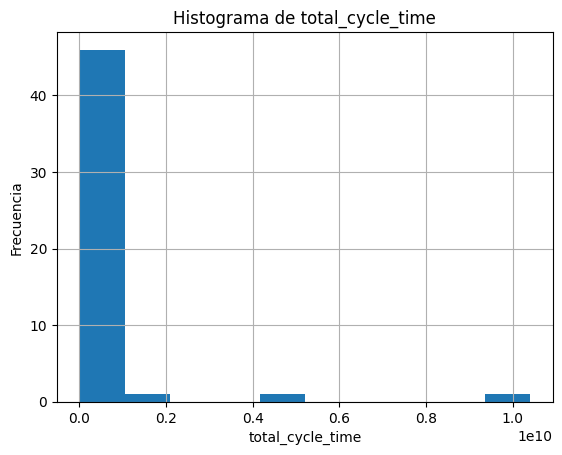

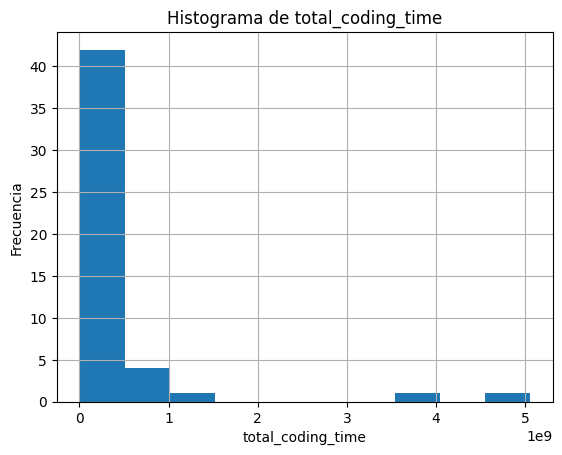

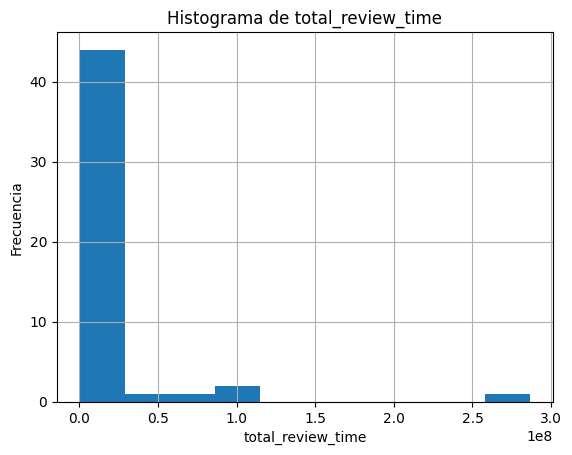

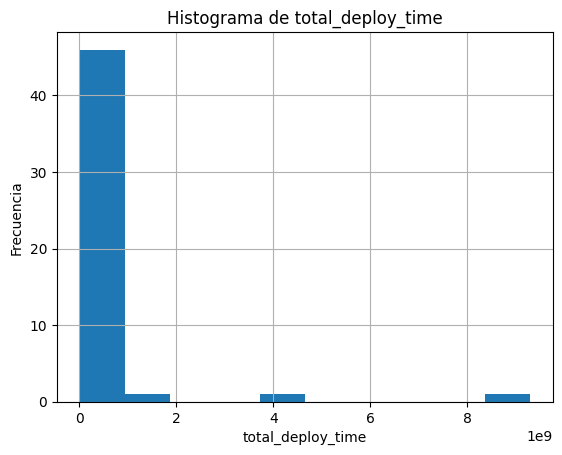

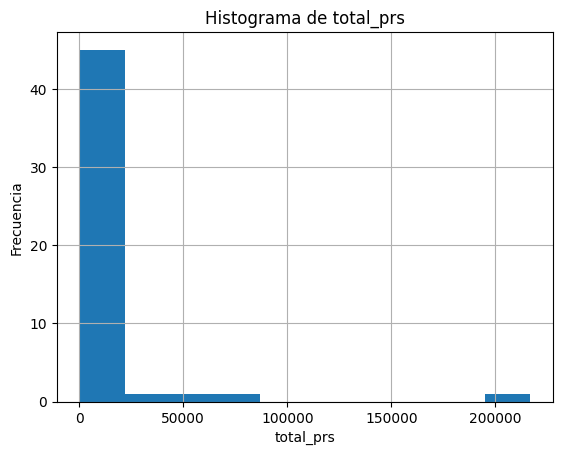

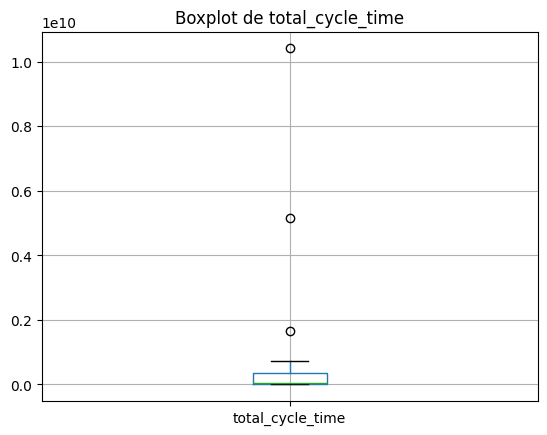

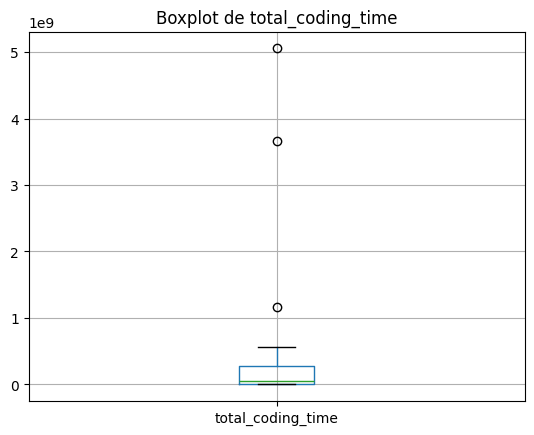

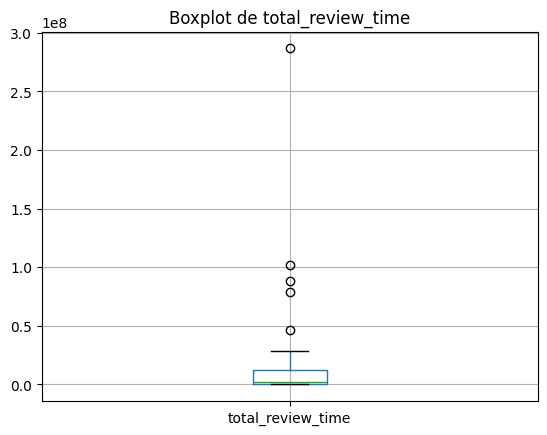

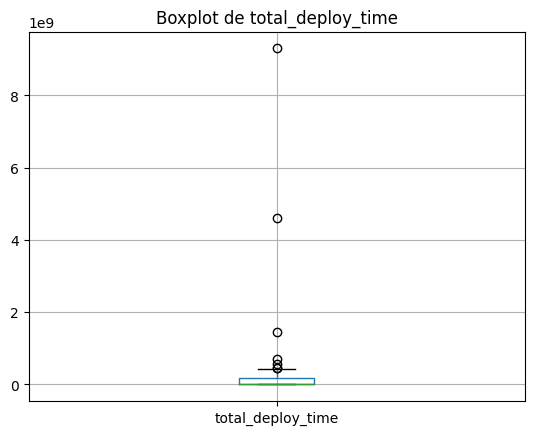

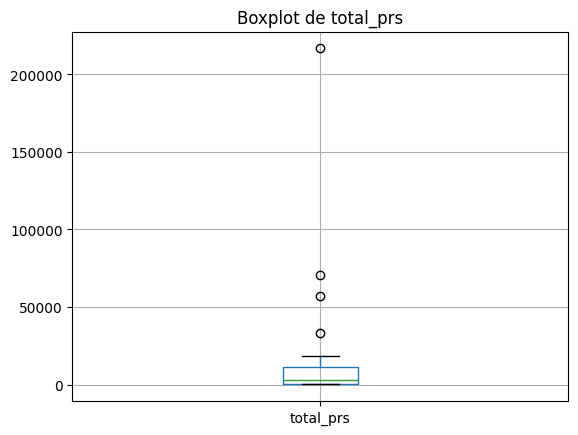

In [56]:
# Identificar columnas numéricas
num_cols = data_without_nulls.select_dtypes(include='number').columns.tolist()

# Generar histogramas para cada variable numérica
for col in num_cols:
    plt.figure()
    data_without_nulls[col].hist()
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# Generar boxplots para cada variable numérica
for col in num_cols:
    plt.figure()
    data_without_nulls.boxplot(column=col)
    plt.title(f'Boxplot de {col}')
    plt.show()

In [64]:
!pip install ace_tools

Matriz de Correlación:
                   total_cycle_time  total_coding_time  total_review_time  \
total_cycle_time           1.000000           0.974831           0.478822   
total_coding_time          0.974831           1.000000           0.523281   
total_review_time          0.478822           0.523281           1.000000   
total_deploy_time          0.998146           0.968562           0.469559   
total_prs                  0.974129           0.938541           0.550952   

                   total_deploy_time  total_prs  
total_cycle_time            0.998146   0.974129  
total_coding_time           0.968562   0.938541  
total_review_time           0.469559   0.550952  
total_deploy_time           1.000000   0.970397  
total_prs                   0.970397   1.000000  


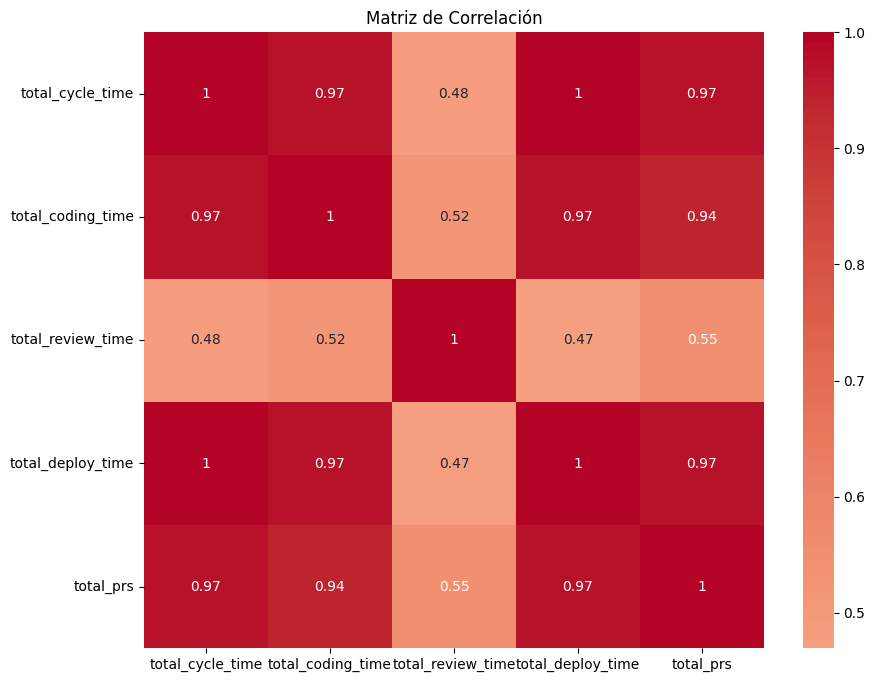

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matriz de correlación
corr_matrix = data_without_nulls[num_cols].corr()

# Mostrar la matriz de correlación
print("Matriz de Correlación:")
print(corr_matrix)

# Crear un mapa de calor de la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
df_without_nulls_timeseries = data_without_nulls.set_index('created_at')


In [ ]:
from sklearn.model_selection import train_test_split

X = data_without_nulls.drop(columns='target')
y = data_without_nulls['target']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

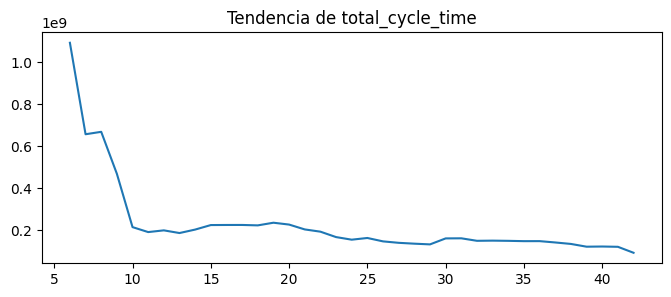

In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# supondremos que ya tienes df.index = fecha y df[col] la métrica
decomp = seasonal_decompose(data_without_nulls['total_cycle_time'], model='additive', period=12)
fig = decomp.trend.plot(figsize=(8,3), title='Tendencia de total_cycle_time')
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 1) crear variable “t” = 0,1,2,... para cada mes
t = np.arange(len(data_without_nulls)).reshape(-1,1)
y = data_without_nulls['total_cycle_time'].values

# 2) entrenar regresión
lr = LinearRegression().fit(t, y)
slope = lr.coef_[0]
print(f"Pendiente estimada: {slope:.2e} unidades/mes")

Pendiente estimada: -4.03e+07 unidades/mes


: 

In [22]:
!pip install business-duration duckdb pandas

In [34]:
import duckdb
import pandas as pd
from business_duration import businessDuration
from datetime import datetime


# Conexión a tu base DuckDB (ajusta el path si es necesario)
con = duckdb.connect("./devlake_data.duckdb", read_only=True)  # ej: "./devlake.duckdb"

query = """
    SELECT
  pj.*,
  ctg.producto,
  ctg.equipo,
  r.url               AS repo_url,
  pr.id               AS pr_id,
  pr.status,
  pr.created_date,
  pr.merged_date,
  -- diferencia en segundos
  date_diff('second', pr.created_date, pr.merged_date) AS coding_time_seconds,
  -- conversión a horas
  date_diff('second', pr.created_date, pr.merged_date) / 3600.0 AS coding_time_hours
FROM projects pj
INNER JOIN catalogo ctg
  ON pj.name = ctg.equipo
INNER JOIN repos r
  ON ctg.project_web_url = r.url
INNER JOIN pull_requests pr
  ON r.id = pr.base_repo_id;
"""

# Leer la tabla como DataFrame
df = con.execute(query).fetchdf()

# Asegurar formatos de fecha
df["created_date"] = pd.to_datetime(df["created_date"])
df["merged_date"] = pd.to_datetime(df["merged_date"])

# Calcular coding_time_hours si no existe
df["coding_time_hours"] = df["coding_time_seconds"] / 3600.0

start_time = datetime.strptime("09:00:00", "%H:%M:%S").time()
end_time = datetime.strptime("17:00:00", "%H:%M:%S").time()

# Función para calcular horas laborales
def calcular_horas_laborales(row):
    return businessDuration(
        startdate=row["created_date"],
        enddate=row["merged_date"],
        starttime=start_time,
        endtime=end_time,
        weekendlist=[6, 7],  # sábado y domingo
        unit='second'
    )

# Aplicar feature laboral
df["coding_time_laboral_hours"] = df.apply(calcular_horas_laborales, axis=1)
df["laboral_ratio"] = df["coding_time_laboral_hours"] / df["coding_time_hours"]
df["is_out_of_schedule"] = df["coding_time_laboral_hours"] == 0
df["is_weekend"] = df["created_date"].dt.weekday >= 5
df["is_night"] = (df["created_date"].dt.hour < 9) | (df["created_date"].dt.hour >= 17)

# (Opcional) Exportar
df.to_parquet("pr_features_laboral.parquet", index=False)

df.groupby(["is_weekend", "is_night"]).size()

is_weekend  is_night
False       False       34988
            True        46187
True        False         533
            True         1609
dtype: int64

In [ ]:
#importa el archivo pr_features_laboral_complete.parquet
nuevo_df = pd.read_parquet("pr_features_laboral.parquet")

#muestra las primeras 5 filas
nuevo_df.head()

#muestra las ultimas 5 filas
nuevo_df.tail()

#muestra las columnas
nuevo_df.columns

TypeError: read_table() got an unexpected keyword argument 'index'

In [27]:
nuevo_df


,name,description,created_at,updated_at,_raw_data_params,_raw_data_table,_raw_data_id,_raw_data_remark,producto,equipo,...,status,created_date,merged_date,coding_time_seconds,coding_time_hours,coding_time_laboral_hours,coding_laboral_ratio,is_out_of_schedule,is_weekend,is_night
0,pulsar-teams-developers,This is an test from create teams.,2024-10-13 14:10:30.369,2024-10-13 14:10:30.369,,,0,,product_name,pulsar-teams-developers,...,MERGED,2023-10-21 03:24:56,2023-10-21 03:52:08,1632,0.453333,0.0,0.0,True,True,True
1,pulsar-teams-developers,This is an test from create teams.,2024-10-13 14:10:30.369,2024-10-13 14:10:30.369,,,0,,product_name,pulsar-teams-developers,...,MERGED,2023-10-21 03:24:56,2023-10-21 03:52:08,1632,0.453333,0.0,0.0,True,True,True
2,pulsar-teams-developers,This is an test from create teams.,2024-10-13 14:10:30.369,2024-10-13 14:10:30.369,,,0,,product_name,pulsar-teams-developers,...,MERGED,2023-10-21 03:51:45,2023-10-21 03:54:12,147,0.040833,0.0,0.0,True,True,True
3,bff-backend-spid,,2024-10-13 09:42:06.424,2024-10-13 09:42:06.424,,,0,,product_name,bff-backend-spid,...,MERGED,2023-11-09 20:40:49,2023-11-09 20:40:59,10,0.002778,0.0,0.0,True,False,True
4,be-points-maintaners,,2024-10-13 09:07:35.084,2024-10-13 09:07:35.084,,,0,,product_name,be-points-maintaners,...,CLOSED,2023-11-14 16:15:48,NaT,<NA>,<NA>,NaN,<NA>,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83312,bff-backend-spid,,2024-10-13 09:42:06.424,2024-10-13 09:42:06.424,,,0,,product_name,bff-backend-spid,...,OPEN,2025-07-17 22:18:04,NaT,<NA>,<NA>,NaN,<NA>,False,False,True
83313,product-price-approval,,2024-10-13 14:03:54.958,2024-10-13 14:03:54.958,,,0,,product_name,product-price-approval,...,MERGED,2025-07-17 22:40:46,2025-07-17 22:46:38,352,0.097778,0.0,0.0,True,False,True
83314,wl-groceries-app,,2025-01-14 19:53:10.958,2025-01-14 19:53:10.958,,,0,,Frontend,wl-groceries-app,...,MERGED,2025-07-17 23:20:25,2025-07-17 23:37:27,1022,0.283889,0.0,0.0,True,False,True
83315,dpt-ops-sre-maintainers,,2024-10-13 11:44:00.961,2024-10-13 11:44:00.961,,,0,,product_name,dpt-ops-sre-maintainers,...,MERGED,2025-07-18 01:00:57,2025-07-18 01:04:07,190,0.052778,0.0,0.0,True,False,True
